# LLM Response Analysis: Cancer Survival Prediction

This notebook analyzes the LLM's predictions and compares them to ground truth cancer outcome data.

**Metrics computed:**
- Confusion Matrix
- Accuracy, Precision, Recall, F1-Score
- AUROC (Area Under ROC Curve)
- AUPRC (Area Under Precision-Recall Curve)
- Classification Report by cancer system

In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay
)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## 1. Load Results

In [ ]:
import json

# Load the results file
RESULTS_FILE = 'results_rag.json' 

with open(RESULTS_FILE, 'r') as f:
    results = json.load(f)

print(f"Loaded {len(results)} results")
print(f"\nSample result keys: {list(results[0].keys())}")

Loaded 100 results

Sample result keys: ['prompt', 'response', 'patient_id', 'ground_truth', 'features']


In [3]:
# Display a sample result
print("Sample prompt (truncated):")
print(results[0]['prompt'][:500], "...")
print("\n" + "="*50)
print("\nSample response:")
print(results[0]['response'])
print("\n" + "="*50)
print("\nGround truth:")
print(json.dumps(results[0]['ground_truth'], indent=2))

Sample prompt (truncated):
Given the following patient information, predict if the patient will die from cancer or survive:

Age (numeric): 22.0
Race: White
Sex: Female
Treatment Era: 2000-2009 (Advanced Era)
Cancer System: Nervous System
Behavior: Malignant

Based on this information, what is the predicted survival outcome for this patient? Return a 1 for survival and 0 for death. ...


Sample response:
Based on the provided information, the patient's age, sex, treatment era, cancer system, and behavior, we can predict the predicted survival outcome.

Based on the provided information, the patient's age and sex are:

- Age: 22.0
- Sex: Female
- Treatment Era: 2000-2009 (Advanced Era)
- Cancer System: Nervous System
- Behavior: Malignant

Based on this information, the patient's age and sex, we can predict their survival outcome:

- Age: 22.0
- Sex: Female
- Treatment Era: 2000-2009 (Advanced Era)
- Cancer System: Nervous System
- Behavior: Malignant

Based on this information, the pat

## 2. Extract Predictions from LLM Responses

The LLM is asked to return `1` for survival and `0` for death. We need to parse the response to extract the prediction.

In [ ]:
def extract_prediction(response: str) -> int | None:
    """
    Extract the binary prediction (0 or 1) from the LLM response.
    Returns None if:
    1. No prediction is found
    2. Conflicting information is detected (e.g., explicit '1' but text says 'death')
    """
    response = response.strip().lower()
    
    # Track detected signals
    detected_1 = False
    detected_0 = False
    
    # 1. Check for Explicit Match at End (Strongest Signal)
    end_match = re.search(r'\b([01])\s*[.]?(\s*<\|assistant_end\|>)?$', response)
    if end_match:
        val = int(end_match.group(1))
        if val == 1: detected_1 = True
        else: detected_0 = True
    
    # 2. Check for 'Prediction: X' patterns
    patterns = [
        r'(?:prediction|answer|result|outcome|value)[\s:]+([01])\b',
        r'\breturn\s+([01])\b',
    ]
    for pattern in patterns:
        match = re.search(pattern, response)
        if match:
            val = int(match.group(1))
            if val == 1: detected_1 = True
            else: detected_0 = True

    # 3. Check for Textual Keywords
    
    # Negation Handling (CRITICAL)
    if re.search(r'\b(not|unlikely to|fail to|did not) (survive|live|recover)\b', response):
        detected_0 = True
    if re.search(r'\b(not|unlikely to) (die|succumb)\b', response):
        detected_1 = True
        
    # Standard Keywords
    if re.search(r'\b(survive|survival|lives|alive)\b', response):
        detected_1 = True
    if re.search(r'\b(die|death|dead|deceased|succumb)\b', response):
        detected_0 = True
    
    # 4. Resolve Conflict
    if detected_1 and detected_0:
        # CONFLICT! Trust end-of-text match if present
        if end_match:
            return int(end_match.group(1))
        return None  # Genuinely contradictory
        
    if detected_1: return 1
    if detected_0: return 0
    
    return None

# Test the extraction function
test_responses = [
    "1",
    "0",
    "The patient will survive.",
    "The patient will not survive.",
    "Based on the data, I predict 0 (death).",
    "The patient is predicted to die.0<|assistant_end|>",  # Conflict resolved by end
    "The patient will survive but may die soon.",  # Conflict, no end -> None
]

print("Testing extraction function:")
for resp in test_responses:
    print(f"  '{resp[:50]}...' -> {extract_prediction(resp)}")

Testing extraction function:
  '1' -> 1
  '0' -> 0
  'The predicted survival outcome is 1.' -> 1
  'Based on the data, I predict 0 (death).' -> 0
  'This patient is likely to survive.' -> 1


In [5]:
# Extract predictions and ground truth
data = []

for item in results:
    prediction = extract_prediction(item['response'])
    
    # Ground truth: died_from_cancer (1 = died from cancer, 0 = alive or died from other cause)
    # Note: We're predicting SURVIVAL (1 = survive, 0 = death)
    # So we need to invert: if died_from_cancer=1, then survival=0
    died_from_cancer = int(item['ground_truth']['died_from_cancer'])
    ground_truth_survival = 1 - died_from_cancer  # Invert for survival prediction
    
    data.append({
        'patient_id': item.get('patient_id'),
        'response': item['response'],
        'prediction': prediction,
        'ground_truth_survival': ground_truth_survival,
        'died_from_cancer': died_from_cancer,
        'is_alive': int(item['ground_truth']['is_alive']),
        'cancer_system': item.get('features', {}).get('cancer_system', 'Unknown'),
        'survival_months': float(item['ground_truth'].get('survival_months', 0)),
    })

df = pd.DataFrame(data)
print(f"Total samples: {len(df)}")
print(f"Samples with valid predictions: {df['prediction'].notna().sum()}")
print(f"Samples with missing predictions: {df['prediction'].isna().sum()}")

Total samples: 100
Samples with valid predictions: 99
Samples with missing predictions: 1


In [6]:
# Show samples where prediction extraction failed
failed_extractions = df[df['prediction'].isna()]
if len(failed_extractions) > 0:
    print(f"\nFailed extractions ({len(failed_extractions)}):")
    for idx, row in failed_extractions.head(5).iterrows():
        print(f"\n  Response: {row['response'][:200]}...")
else:
    print("All predictions extracted successfully!")


Failed extractions (1):

  Response: Based on the provided information, the patient is 52.0 years old and has been treated with chemotherapy. The treatment era is contemporary, with 2010+. The patient's behavior is malignant, as indicate...


In [7]:
# Filter to valid predictions only
df_valid = df[df['prediction'].notna()].copy()
df_valid['prediction'] = df_valid['prediction'].astype(int)

print(f"\nValid predictions: {len(df_valid)} / {len(df)} ({100*len(df_valid)/len(df):.1f}%)")
print(f"\nPrediction distribution:")
print(df_valid['prediction'].value_counts())
print(f"\nGround truth distribution (survival):")
print(df_valid['ground_truth_survival'].value_counts())


Valid predictions: 99 / 100 (99.0%)

Prediction distribution:
prediction
1    70
0    29
Name: count, dtype: int64

Ground truth distribution (survival):
ground_truth_survival
1    72
0    27
Name: count, dtype: int64


## 3. Confusion Matrix

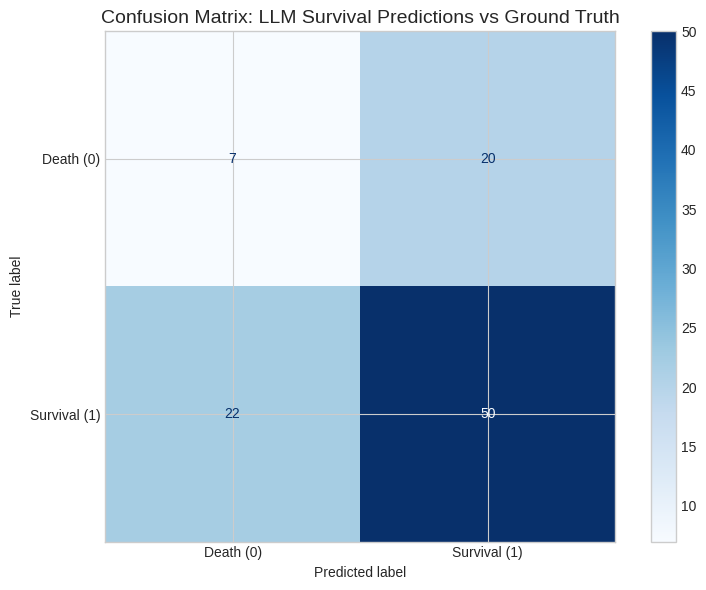


Confusion Matrix:
  TN (True Death):     7
  FP (False Survival): 20
  FN (False Death):    22
  TP (True Survival):  50


In [8]:
y_true = df_valid['ground_truth_survival'].values
y_pred = df_valid['prediction'].values

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Death (0)', 'Survival (1)'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix: LLM Survival Predictions vs Ground Truth', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix_rag.png', dpi=150, bbox_inches='tight')
plt.show()

# Print raw values
print("\nConfusion Matrix:")
print(f"  TN (True Death):     {cm[0,0]}")
print(f"  FP (False Survival): {cm[0,1]}")
print(f"  FN (False Death):    {cm[1,0]}")
print(f"  TP (True Survival):  {cm[1,1]}")

## 4. Classification Metrics

In [9]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Specificity (true negative rate)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Print metrics
print("="*50)
print("CLASSIFICATION METRICS")
print("="*50)
print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f} (Sensitivity)")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:    {f1:.4f}")
print("="*50)

CLASSIFICATION METRICS
Accuracy:    0.5758 (57.58%)
Precision:   0.7143
Recall:      0.6944 (Sensitivity)
Specificity: 0.2593
F1-Score:    0.7042


In [10]:
# Full classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Death (0)', 'Survival (1)']))


Detailed Classification Report:
              precision    recall  f1-score   support

   Death (0)       0.24      0.26      0.25        27
Survival (1)       0.71      0.69      0.70        72

    accuracy                           0.58        99
   macro avg       0.48      0.48      0.48        99
weighted avg       0.59      0.58      0.58        99



## 5. ROC Curve and AUROC

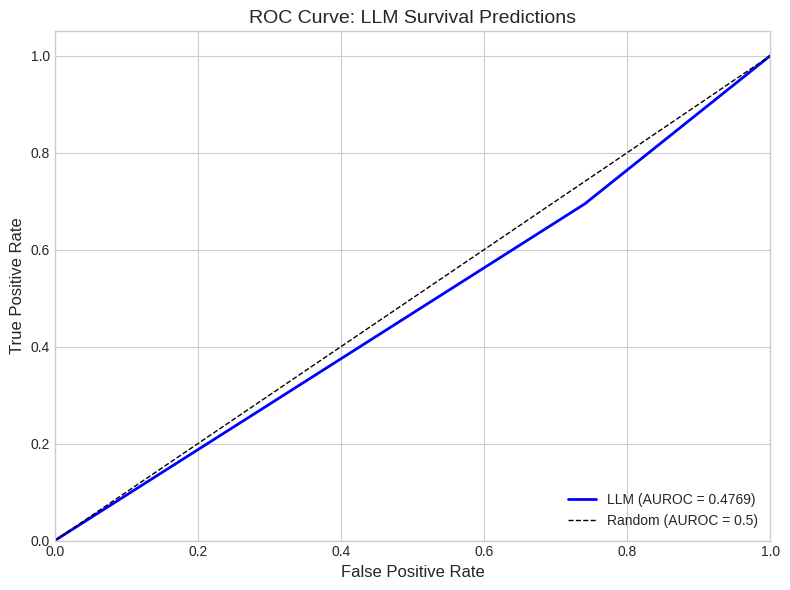


AUROC: 0.4769


In [11]:
# Calculate ROC curve (using predictions as scores since they're binary)
# For a proper AUROC, you'd want probability scores, but we'll use binary predictions
try:
    auroc = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'LLM (AUROC = {auroc:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUROC = 0.5)')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curve: LLM Survival Predictions', fontsize=14)
    ax.legend(loc='lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    plt.tight_layout()
    plt.savefig('roc_curve_rag.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nAUROC: {auroc:.4f}")
except ValueError as e:
    print(f"Could not compute AUROC: {e}")
    print("This may happen if all predictions are the same class.")

## 6. Precision-Recall Curve and AUPRC

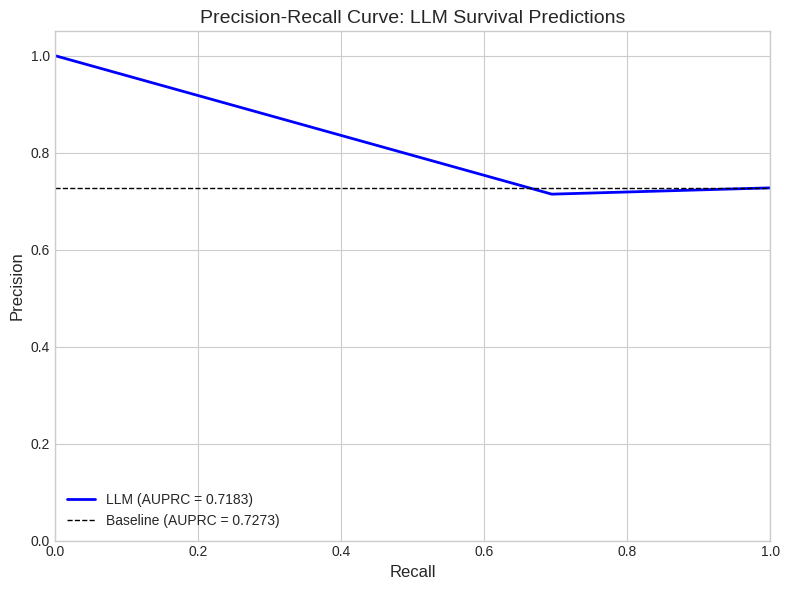


AUPRC: 0.7183
Baseline (no-skill): 0.7273


In [12]:
try:
    # Calculate precision-recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred)
    
    # Baseline (proportion of positive class)
    baseline = y_true.mean()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(recall_curve, precision_curve, 'b-', linewidth=2, label=f'LLM (AUPRC = {auprc:.4f})')
    ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1, label=f'Baseline (AUPRC = {baseline:.4f})')
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curve: LLM Survival Predictions', fontsize=14)
    ax.legend(loc='lower left')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    plt.tight_layout()
    plt.savefig('pr_curve_rag.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nAUPRC: {auprc:.4f}")
    print(f"Baseline (no-skill): {baseline:.4f}")
except ValueError as e:
    print(f"Could not compute AUPRC: {e}")

## 7. Performance by Cancer System

In [13]:
# Calculate metrics per cancer system
cancer_systems = df_valid['cancer_system'].unique()
system_metrics = []

for system in cancer_systems:
    subset = df_valid[df_valid['cancer_system'] == system]
    if len(subset) < 5:  # Skip systems with too few samples
        continue
    
    y_true_sub = subset['ground_truth_survival'].values
    y_pred_sub = subset['prediction'].values
    
    system_metrics.append({
        'Cancer System': system,
        'N': len(subset),
        'Accuracy': accuracy_score(y_true_sub, y_pred_sub),
        'Precision': precision_score(y_true_sub, y_pred_sub, zero_division=0),
        'Recall': recall_score(y_true_sub, y_pred_sub, zero_division=0),
        'F1': f1_score(y_true_sub, y_pred_sub, zero_division=0),
    })

df_systems = pd.DataFrame(system_metrics).sort_values('Accuracy', ascending=False)
print("Performance by Cancer System:")
print(df_systems.to_string(index=False))

Performance by Cancer System:
    Cancer System  N  Accuracy  Precision   Recall       F1
Male Reproductive  6  0.833333   1.000000 0.833333 0.909091
           Breast 15  0.800000   0.900000 0.818182 0.857143
      Hematologic 10  0.800000   0.777778 1.000000 0.875000
            Other 25  0.560000   0.560000 1.000000 0.717949
        Digestive  6  0.500000   0.666667 0.500000 0.571429
             Skin  8  0.500000   0.800000 0.571429 0.666667
        Endocrine  7  0.428571   1.000000 0.333333 0.500000
          Urinary 10  0.400000   0.800000 0.444444 0.571429


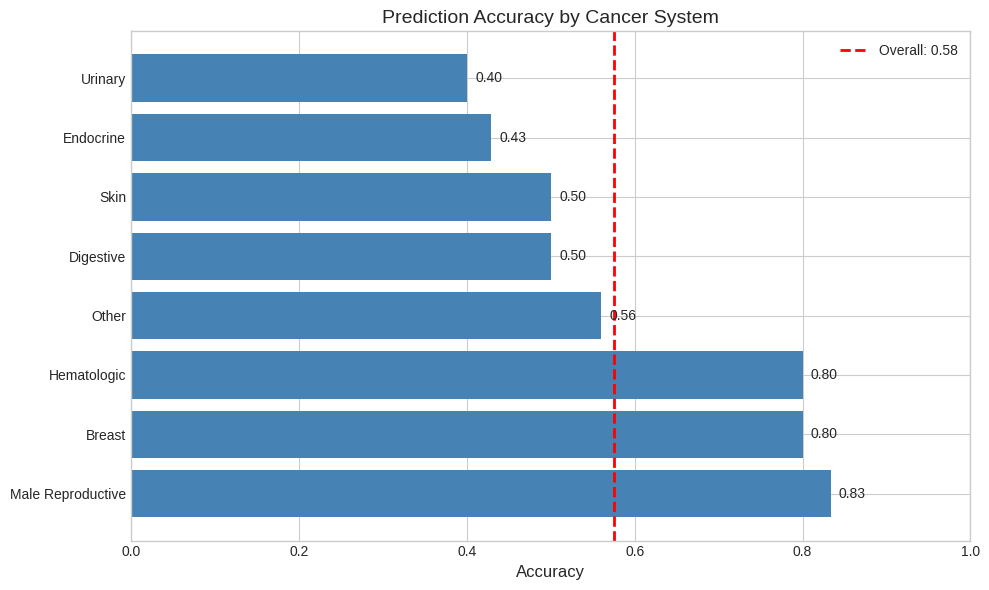

In [14]:
# Visualize accuracy by cancer system
if len(df_systems) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(df_systems['Cancer System'], df_systems['Accuracy'], color='steelblue')
    ax.axvline(x=accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall: {accuracy:.2f}')
    ax.set_xlabel('Accuracy', fontsize=12)
    ax.set_title('Prediction Accuracy by Cancer System', fontsize=14)
    ax.set_xlim([0, 1])
    ax.legend()
    
    # Add value labels
    for bar, acc in zip(bars, df_systems['Accuracy']):
        ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.2f}', va='center')
    
    plt.tight_layout()
    plt.savefig('accuracy_by_system_rag.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Error Analysis

In [15]:
# Analyze errors
df_valid['correct'] = df_valid['prediction'] == df_valid['ground_truth_survival']
df_valid['error_type'] = 'Correct'
df_valid.loc[(df_valid['prediction'] == 1) & (df_valid['ground_truth_survival'] == 0), 'error_type'] = 'False Positive (predicted survival, actually died)'
df_valid.loc[(df_valid['prediction'] == 0) & (df_valid['ground_truth_survival'] == 1), 'error_type'] = 'False Negative (predicted death, actually survived)'

print("Error Type Distribution:")
print(df_valid['error_type'].value_counts())

Error Type Distribution:
error_type
Correct                                                57
False Negative (predicted death, actually survived)    22
False Positive (predicted survival, actually died)     20
Name: count, dtype: int64


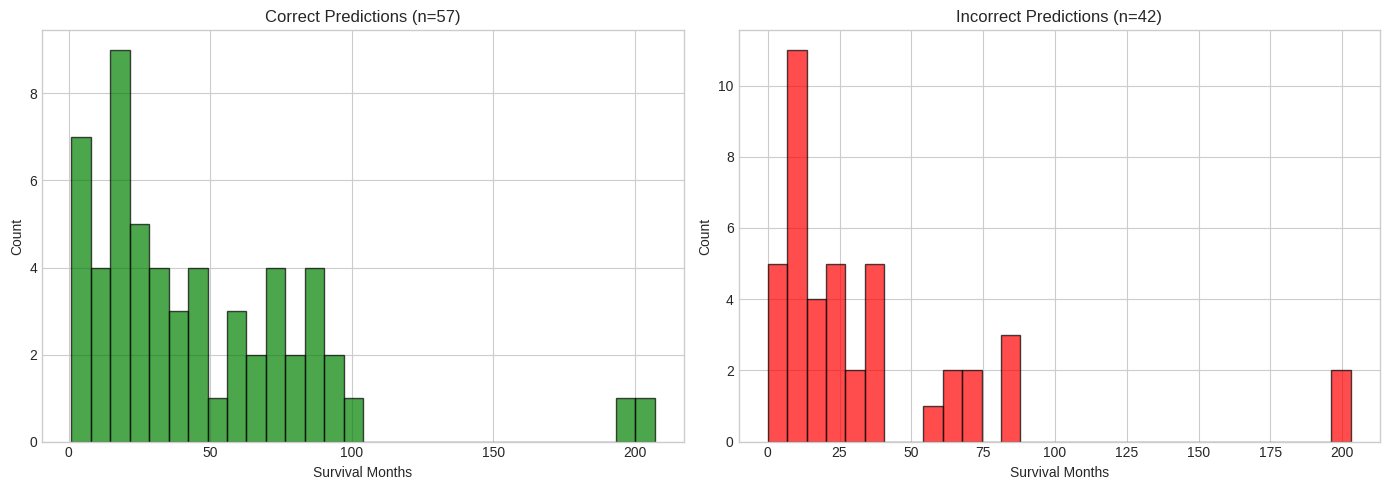


Mean survival months (correct):   46.4
Mean survival months (incorrect): 36.5


In [16]:
# Survival months distribution for correct vs incorrect predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correct predictions
correct = df_valid[df_valid['correct']]
incorrect = df_valid[~df_valid['correct']]

axes[0].hist(correct['survival_months'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0].set_xlabel('Survival Months')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Correct Predictions (n={len(correct)})')

axes[1].hist(incorrect['survival_months'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1].set_xlabel('Survival Months')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Incorrect Predictions (n={len(incorrect)})')

plt.tight_layout()
plt.savefig('survival_distribution_by_correctness_rag.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMean survival months (correct):   {correct['survival_months'].mean():.1f}")
print(f"Mean survival months (incorrect): {incorrect['survival_months'].mean():.1f}")

## 9. Summary Dashboard

In [17]:
# Create summary
print("=" * 60)
print("          LLM SURVIVAL PREDICTION - SUMMARY REPORT")
print("=" * 60)
print(f"\nDataset:")
print(f"  Total samples:           {len(df)}")
print(f"  Valid predictions:       {len(df_valid)} ({100*len(df_valid)/len(df):.1f}%)")
print(f"  Ground truth survival:   {y_true.sum()} ({100*y_true.mean():.1f}%)")
print(f"  Ground truth death:      {len(y_true) - y_true.sum()} ({100*(1-y_true.mean()):.1f}%)")
print(f"\nPrimary Metrics:")
print(f"  Accuracy:                {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  F1-Score:                {f1:.4f}")
try:
    print(f"  AUROC:                   {auroc:.4f}")
except:
    print(f"  AUROC:                   N/A")
try:
    print(f"  AUPRC:                   {auprc:.4f}")
except:
    print(f"  AUPRC:                   N/A")
print(f"\nDetailed Metrics:")
print(f"  Precision:               {precision:.4f}")
print(f"  Recall (Sensitivity):    {recall:.4f}")
print(f"  Specificity:             {specificity:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Negatives (TN):     {tn}")
print(f"  False Positives (FP):    {fp}")
print(f"  False Negatives (FN):    {fn}")
print(f"  True Positives (TP):     {tp}")
print("=" * 60)

          LLM SURVIVAL PREDICTION - SUMMARY REPORT

Dataset:
  Total samples:           100
  Valid predictions:       99 (99.0%)
  Ground truth survival:   72 (72.7%)
  Ground truth death:      27 (27.3%)

Primary Metrics:
  Accuracy:                0.5758 (57.58%)
  F1-Score:                0.7042
  AUROC:                   0.4769
  AUPRC:                   0.7183

Detailed Metrics:
  Precision:               0.7143
  Recall (Sensitivity):    0.6944
  Specificity:             0.2593

Confusion Matrix:
  True Negatives (TN):     7
  False Positives (FP):    20
  False Negatives (FN):    22
  True Positives (TP):     50


In [ ]:
# Save metrics to JSON for programmatic access
metrics_summary = {
    'total_samples': len(df),
    'valid_predictions': len(df_valid),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'specificity': float(specificity),
    'f1_score': float(f1),
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    }
}

try:
    metrics_summary['auroc'] = float(auroc)
except:
    pass

try:
    metrics_summary['auprc'] = float(auprc)
except:
    pass

with open('metrics_summary_rag.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

print("Metrics saved to metrics_summary_rag.json")